In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import lsq_linear
from scipy.optimize import curve_fit
from scipy.odr import *

from astropy.coordinates import SkyCoord
from astropy.time import Time
from skyfield.api import load

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
#---------------------------------------
# Input some parameters from parm_env.ipynb
#---------------------------------------
%run parm_env_all.ipynb

['Ka' 'Ka' 'Q' 'B6' 'B6' 'K' 'B7' 'K' 'Ka' 'B7' 'B6' 'B7' 'B3' 'B6' 'B6'
 'B4' 'B4']


### Fitting the Proper Motion without the parallax


$\alpha(t)$ = $\mu_{\alpha}$ cos$\delta$ * $(t - t_{0}$) + $\alpha(t_{0})$

$\delta(t)$ = $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{0}$) + $\delta(t_{0})$

---

y $\hspace{4.8mm}$= $\hspace{10mm}$ m * x $\hspace{11mm}$ + c

$\alpha(t)$ = $\mu_{\alpha}$ cos$\delta$ * $(t - t_{B4}$) + $\alpha(t_{B4})$

$\delta(t)$ = $\mu_{\delta}$ $\hspace{8.5mm}$ *  $(t - t_{B4}$) + $\delta(t_{B4})$

In [3]:
# y: corvert the unit of ra and dec from deg to mas
ra_mas_arr        = deg2mas(ra_deg_arr)                 # Right Ascension [mas]
dec_mas_arr       = deg2mas(dec_deg_arr)                # Declination     [mas]
radec_err_mas_arr = deg2mas(radec_err_deg_arr)          # Uncertainties of RA & Dec [mas]

# x: calculate the observational time difference [yr]
time_diff_yr_arr  = time_yr_arr - time_yr_std

# Set the y & x for the linear regression
y_ra_arr          = drop_arr(ra_mas_arr, drop_list)             # RA(t)     [mas]
y_err_ra_arr      = drop_arr(radec_err_mas_arr, drop_list)      # Uncertainties of RA(t) [mas]
x_ra_arr          = drop_arr(time_diff_yr_arr, drop_list)       # t - t_0   [yr]

y_dec_arr         = drop_arr(dec_mas_arr, drop_list)            # Dec(t)    [mas]
y_err_dec_arr     = drop_arr(radec_err_mas_arr, drop_list)      # Uncertainties of Dec(t) [mas]
x_dec_arr         = drop_arr(time_diff_yr_arr, drop_list)       # t - t_0   [yr]

wt_y_err_ra_arr   = np.divide(1, y_err_ra_arr)
wt_y_err_dec_arr  = np.divide(1, y_err_dec_arr)

### Linear regression

In [4]:
%%time
###--------------------------------------------------
# linear regression
# Python package numpy.polyfit with order = 1

# (1) RA
ra_m, ra_c, ra_m_err, ra_c_err, ra_chi2, ra_chi2_dof, ra_r = \
get_parm_from_lstqrt_linear(x_ra_arr, y_ra_arr)

# wrighted with the uncertainties of RA
ra_wt_m, ra_wt_c, ra_wt_m_err, ra_wt_c_err, ra_wt_chi2, ra_wt_chi2_dof, ra_wt_r = \
get_parm_from_lstqrt_linear(x_ra_arr, y_ra_arr, wt_y_err_ra_arr)


# (2) Dec
dec_m, dec_c, dec_m_err, dec_c_err, dec_chi2, dec_chi2_dof, dec_r = \
get_parm_from_lstqrt_linear(x_dec_arr, y_dec_arr)

# wrighted with the uncertainties of dec
dec_wt_m, dec_wt_c, dec_wt_m_err, dec_wt_c_err, dec_wt_chi2, dec_wt_chi2_dof, dec_wt_r = \
get_parm_from_lstqrt_linear(x_dec_arr, y_dec_arr, wt_y_err_dec_arr)

CPU times: user 5.51 ms, sys: 1.94 ms, total: 7.44 ms
Wall time: 5.86 ms


### Set the parameters of the fitting results

In [5]:
#----------------------------------------------------
# Observation
#----------------------------------------------------
# Observational time [year]
t0_yr      = time_yr_arr[0]
tf_yr      = time_yr_arr[-1]
t_std_yr   = time_yr_std

# Time different [yr] from the first fitting plot (JVLA K) btw the reference (ALMA B4)
t0_diff_yr = t0_yr - t_std_yr
tf_diff_yr = tf_yr - t_std_yr

# uncertainty for ra & dec
err_arcs_arr    = radec_err_arcs_arr
ra_err_sec_arr  = ra_arcs2sec(radec_err_arcs_arr) / np.cos(np.deg2rad(dec_deg_std))


#----------------------------------------------------
# Fitting result
#----------------------------------------------------
# y = mx + c

# (1)   m: pm_ra, pm_dec

# (1.1) Proper motion in the direction of ra

# unit: [mas yr-1]
pm_ra_fit_masyr             = ra_m           
pm_ra_err_fit_masyr         = ra_m_err       
pm_ra_fit_wt_masyr          = ra_wt_m        
pm_ra_err_fit_wt_masyr      = ra_wt_m_err      

# Limiting floats to two decimal points
pm_ra_fit_masyr_fmt         = float('%.2f' % pm_ra_fit_masyr)
pm_ra_err_fit_masyr_fmt     = float('%.2f' % pm_ra_err_fit_masyr)
pm_ra_fit_wt_masyr_fmt      = float('%.2f' % pm_ra_fit_wt_masyr)
pm_ra_err_fit_wt_masyr_fmt  = float('%.2f' % pm_ra_err_fit_wt_masyr)

pm_ra_fit_secyr             = ra_arcs2sec(pm_ra_fit_masyr* 1e-3)    #* np.cos(np.deg2rad(dec_deg_std))
pm_ra_fit_wt_secyr          = ra_arcs2sec(pm_ra_fit_wt_masyr* 1e-3) #* np.cos(np.deg2rad(dec_deg_std))


# (1.2) Proper motion in the direction of dec

# unit: [mas yr-1]
pm_dec_fit_masyr            = dec_m          
pm_dec_err_fit_masyr        = dec_m_err      
pm_dec_fit_wt_masyr         = dec_wt_m       
pm_dec_err_fit_wt_masyr     = dec_wt_m_err   

# Limiting floats to two decimal points
pm_dec_fit_masyr_fmt        = float('%.2f' % pm_dec_fit_masyr)
pm_dec_err_fit_masyr_fmt    = float('%.2f' % pm_dec_err_fit_masyr)
pm_dec_fit_wt_masyr_fmt     = float('%.2f' % pm_dec_fit_wt_masyr)
pm_dec_err_fit_wt_masyr_fmt = float('%.2f' % pm_dec_err_fit_wt_masyr)

# unit: [arcs yr-1]
pm_dec_fit_arcsyr            = pm_dec_fit_masyr    * 1e-3
pm_dec_fit_wt_arcsyr         = pm_dec_fit_wt_masyr * 1e-3


# (2)   c: ra_0, dec_0

# (2.1) ra_0

# unit: [mas]
ra_0_fit_mas          = ra_c
ra_0_err_fit_mas      = ra_c_err
ra_0_fit_wt_mas       = ra_wt_c
ra_0_err_fit_wt_mas   = ra_wt_c_err

# unit: [deg]  
ra_0_fit_deg        = mas2deg(ra_0_fit_mas)
ra_0_err_fit_deg    = mas2deg(ra_0_err_fit_mas)
ra_0_fit_wt_deg     = mas2deg(ra_0_fit_wt_mas)
ra_0_err_fit_wt_deg = mas2deg(ra_0_err_fit_wt_mas)


# (2.2) dec_0

# unit: [mas]
dec_0_fit_mas          = dec_c
dec_0_err_fit_mas      = dec_c_err
dec_0_fit_wt_mas       = dec_wt_c
dec_0_err_fit_wt_mas   = dec_wt_c_err

# unit: [deg]  
dec_0_fit_deg        = mas2deg(dec_0_fit_mas)
dec_0_err_fit_deg    = mas2deg(dec_0_err_fit_mas)
dec_0_fit_wt_deg     = mas2deg(dec_0_fit_wt_mas)
dec_0_err_fit_wt_deg = mas2deg(dec_0_err_fit_wt_mas)

# (2.3) ra_0 & dec_0

# unit: [sec; arcs]
ra_0_fit_sec, dec_0_fit_arcs       = radec_degdeg2secacrs(ra_0_fit_deg, dec_0_fit_deg)
ra_0_fit_wt_sec, dec_0_fit_wt_arcs = radec_degdeg2secacrs(ra_0_fit_wt_deg, dec_0_fit_wt_deg)

ra_0_err_fit_sec      = ra_sec2arcs(ra_0_err_fit_wt_mas/36e2) * np.cos(np.deg2rad(dec_deg_std))
ra_0_err_fit_wt_sec   = ra_sec2arcs(ra_0_err_fit_wt_mas/36e2) * np.cos(np.deg2rad(dec_deg_std))
dec_0_err_fit_arcs    = dec_0_err_fit_wt_mas/36e2
dec_0_err_fit_wt_arcs = dec_0_err_fit_wt_mas/36e2

In [6]:
# Drop the non-fitting obs. for plotting

# Time
time_yr_fit_arr      = drop_arr(time_yr_arr, drop_list)
time_ymd_fit_arr     = drop_arr(time_ymd_arr, drop_list)
time_diff_yr_fit_arr = drop_arr(time_diff_yr_arr, drop_list)

# ra
ra_s_fit_arr       = drop_arr(ra_s_arr, drop_list)
ra_mas_fit_arr     = drop_arr(ra_mas_arr, drop_list)

# dec
dec_s_fit_arr      = drop_arr(dec_s_arr, drop_list)
dec_mas_fit_arr    = drop_arr(dec_mas_arr, drop_list)

# err
ra_err_sec_fit_arr    = drop_arr(ra_err_sec_arr, drop_list)
err_arcs_fit_arr      = drop_arr(err_arcs_arr, drop_list)
radec_err_mas_fit_arr = drop_arr(radec_err_mas_arr, drop_list)

# Plot
color_fit_list = drop_arr(color_list, drop_list)
Band_fit_arr   = drop_arr(Band_arr, drop_list)

### Fitting results

In [7]:
#----------------------------------------------------
# Fitting result
print ('Fitting result:\n')

print ('#------------------------------------------------------')
print ('(1) Without weighting the uncertainties of ra & dec\n')

print ('- Proper motion (RA)  =  {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_ra_fit_masyr, pm_ra_err_fit_masyr))
print ('- Proper motion (Dec) = {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_dec_fit_masyr, pm_dec_err_fit_masyr))
print ('- RA_0  \t      = {0:.2f} +- {1:.2f} [mas]'.format(ra_0_fit_mas , ra_0_err_fit_mas))
print ('- Dec_0 \t      = {0:.2f} +- {1:.2f} [mas]'.format(dec_0_fit_mas, dec_0_err_fit_mas))

print ('\nRA')
print ('- Chi square = {0:.2f}'.format(ra_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(ra_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(ra_r))

print ('\nDec')
print ('- Chi square = {0:.2f}'.format(dec_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(dec_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(dec_r))

print ('\n#------------------------------------------------------')
print ('(2) Weighting the uncertainties of ra & dec\n')

print ('- Proper motion (RA)  =  {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_ra_fit_wt_masyr, pm_ra_err_fit_wt_masyr))
print ('- Proper motion (Dec) = {0:.2f} +- {1:.2f} [mas yr-1]'.format(pm_dec_fit_wt_masyr, pm_dec_err_fit_wt_masyr))
print ('- RA_0  \t      = {0:.2f} +- {1:.2f} [mas]'.format(ra_0_fit_wt_mas , ra_0_err_fit_wt_mas))
print ('- Dec_0 \t      = {0:.2f} +- {1:.2f} [mas]'.format(dec_0_fit_wt_mas, dec_0_err_fit_wt_mas))

print ('\nRA')
print ('- Chi square = {0:.2f}'.format(ra_wt_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(ra_wt_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(ra_wt_r))

print ('\nDec')
print ('- Chi square = {0:.2f}'.format(dec_wt_chi2))
print ('- Chi square / Degree of freedom = {0:.2f}'.format(dec_wt_chi2_dof))
print ('- Correlation coefficient = {0:.2f}'.format(dec_wt_r))

Fitting result:

#------------------------------------------------------
(1) Without weighting the uncertainties of ra & dec

- Proper motion (RA)  =  11.82 +- 4.10 [mas yr-1]
- Proper motion (Dec) = -13.80 +- 3.76 [mas yr-1]
- RA_0  	      = 188256466.68 +- 10.03 [mas]
- Dec_0 	      = 112412035.32 +- 9.18 [mas]

RA
- Chi square = 979.49
- Chi square / Degree of freedom = 122.44
- Correlation coefficient = 0.54

Dec
- Chi square = 820.50
- Chi square / Degree of freedom = 102.56
- Correlation coefficient = 0.66

#------------------------------------------------------
(2) Weighting the uncertainties of ra & dec

- Proper motion (RA)  =  8.95 +- 2.08 [mas yr-1]
- Proper motion (Dec) = -14.64 +- 1.07 [mas yr-1]
- RA_0  	      = 188256463.17 +- 2.60 [mas]
- Dec_0 	      = 112412035.03 +- 1.33 [mas]

RA
- Chi square = 3.02
- Chi square / Degree of freedom = 0.38
- Correlation coefficient = 0.73

Dec
- Chi square = 0.80
- Chi square / Degree of freedom = 0.10
- Correlation coefficient = 0.9

### Plot the fitting results

In [8]:
def plot_ra_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt): 
    
    # Plot the fitting result (pm_RA*cos(dec) v.s. Time)
    # a = pm_ra * cos(dec)
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_ra_arr):

        # x: t [yr]
        time_yr          = time_yr_fit_arr[i]

        # y: RA(t)  [sec]
        ra_sec           = ra_s_fit_arr[i]      
        # uncertainty for ra [sec]
        ra_err_sec       = ra_err_sec_fit_arr[i]

        # plot
        ax.errorbar(x    = time_yr, \
                    y    = ra_sec, \
                    yerr = ra_err_sec, \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t       = np.linspace(t0_diff_yr, tf_diff_yr+5, 20)
    t_shift = t + time_yr_std

    # y = a                  * x + b
    # y = pm_ra*cos(dec) * x + ra_0

    
    y_ra_fit_sec = fit_m*t + fit_c


    # plot the fitting result
    ax.plot(t_shift, y_ra_fit_sec, '--', color='tab:blue', label='model w/o parallax')

    #----------------------------------------------------
    # Set the figure
    # ax.set_title('pm_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('Epoch [yr]', fontsize=12)
    ax.set_ylabel(r'$\alpha$ (from %sh$\,$%ss) [sec]'%(ra_hour_int, ra_minute_int), fontsize=12)
    ax.set_xlim(2016, 2023)
    ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    # set the major and minor tickers
    #ax.xaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_major_locator(MultipleLocator(0.002))
    #ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.001))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='lower right')

    plt.savefig(plot_savefig_name)
    plt.show()

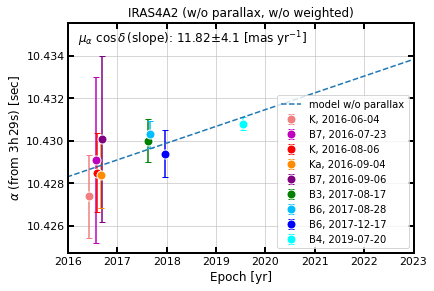

In [9]:
fit_m = pm_ra_fit_secyr
fit_c = ra_0_fit_sec
plot_title_name    = 'IRAS4A2 (w/o parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeRA_wo_prllx.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_masyr_fmt

plot_ra_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

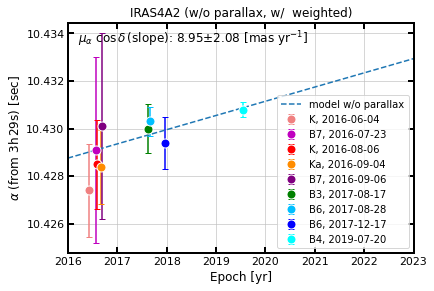

In [10]:
fit_m = pm_ra_fit_wt_secyr
fit_c = ra_0_fit_wt_sec
plot_title_name   = 'IRAS4A2 (w/o parallax, w/  weighted)'
plot_savefig_name = '%s4A2_TimeRA_wo_prllx_wt.pdf'%(path_figure)
plot_m_txt        = pm_ra_fit_wt_masyr_fmt
plot_m_err_txt    = pm_ra_err_fit_wt_masyr_fmt

plot_ra_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [11]:
def plot_dec_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt): 

    # Plot the fitting result (pm_Dec v.s. Time)
    # a = pm_dec
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_dec_arr):

        # x: t [yr]
        time_yr       = time_yr_fit_arr[i]

        # y: Dec(t) [arcs]
        dec_arcs      = dec_s_fit_arr[i]      
        # uncertainty for dec
        err_arcs      = err_arcs_fit_arr[i]

        # plot
        ax.errorbar(x    = time_yr, \
                    y    = dec_arcs, \
                    yerr = err_arcs, \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t       = np.linspace(t0_diff_yr, tf_diff_yr, 20)
    t_shift = t + time_yr_std

    # y = a          * x + b
    # y = pm_dec * x + dec_0
    y_dec_fit_sec = fit_m*t + fit_c

    # plot the fitting result
    ax.plot(t_shift, y_dec_fit_sec, '--', color='tab:blue', label='model w/o parallax')

    #----------------------------------------------------
    # Set the figure
    # ax.set_title('pm_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('Epoch [yr]', fontsize=12)
    ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=12)
    ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend()

    plt.savefig(plot_savefig_name)
    plt.show()

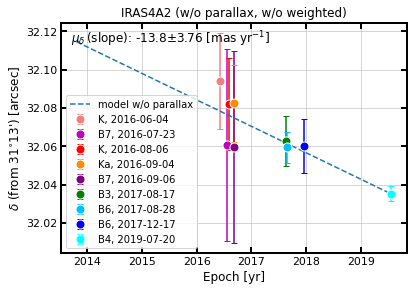

In [12]:
fit_m = pm_dec_fit_arcsyr
fit_c = dec_0_fit_arcs
plot_title_name    = 'IRAS4A2 (w/o parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeDec_wo_prllx.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_masyr_fmt

plot_dec_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

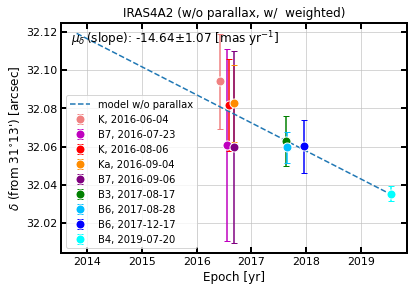

In [13]:
fit_m = pm_dec_fit_wt_arcsyr
fit_c = dec_0_fit_wt_arcs
plot_title_name    = 'IRAS4A2 (w/o parallax, w/  weighted)'
plot_savefig_name  = '%s4A2_TimeDec_wo_prllx_wt.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_wt_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_wt_masyr_fmt

plot_dec_time(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [14]:
def plot_ra_dec(pm_ra, ra_0, pm_dec, dec_0, pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, \
                plot_title_name, plot_savefig_name):
    
    # Plot the fitting result (RA v.s. Dec)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

    #---------------------------------------
    # Plot the observations
    for i, band in enumerate(Band_arr):

        # x: ra
        ra_sec        = ra_s_arr[i]   
        # y: dec
        dec_arcs      = dec_s_arr[i]  
        # uncertainty for the coordinate
        err_arcs      = radec_err_arcs_arr[i]
        ra_err_sec    = ra_err_sec_arr[i]

        markeredgecolor = 'w' if i in drop_list else 'k'
        
        ax.errorbar(x    = ra_sec,\
                    y    = dec_arcs,\
                    xerr = ra_err_sec,\
                    yerr = err_arcs ,\
                    fmt='o', color = color_list[i],\
                    alpha=0.8, markersize=9, markeredgecolor=markeredgecolor, markeredgewidth=2, capsize=3,\
                    label=band+', '+time_ymd_arr[i])

        #---------------------------------------
        # Plot the fitting result with corresponding observational time 

        # Time
        t_diff_yr         = time_yr_arr[i] - time_yr_std

        # x: ra(t)
        # y: dec(t)
        ra_fit_sec        = pm_ra  * t_diff_yr + ra_0
        dec_fit_arcs      = pm_dec * t_diff_yr + dec_0 

        #ax.plot(ra_fit_sec, dec_fit_arcs, color = color_list[i], alpha= 0.8, \
        #        marker='o', fillstyle = 'none', markeredgewidth=2, markersize=10, zorder=10)

    #---------------------------------------
    # plot the fitting result

    # Time
    t = np.linspace(-15, 5, 20)

    # x: ra(t)  [sec]
    # y: dec(t) [arcs]
    y_ra_fit_sec   = pm_ra  *t + ra_0
    y_dec_fit_arcs = pm_dec *t + dec_0

    # plot the fitting result
    ax.plot(y_ra_fit_sec, y_dec_fit_arcs, '--', color='tab:blue', label='model w/o parallax')

    #---------------------------------------
    # Set the figure
    ax.set_title(plot_title_name, fontsize=14)
    ax.set_xlabel(r'$\alpha$ (from %sh$\,$%ss) [sec]'%(ra_hour_int, ra_minute_int), fontsize=14)
    ax.set_ylabel(r"$\delta$ (from %s$^{\circ}$%s') [arcsec]"%(dec_deg_int, dec_arcm_int), fontsize=14)

    ax.set_xlim(10.435, 10.42)
    ax.set_ylim(32.0, 32.25)

    ax.text(0.02, 0.96, r'$\mu_{\alpha}$ $\cos\,\delta\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_ra_fmt, pm_ra_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.02, 0.92, r'$\mu_{\delta}\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_dec_fmt, pm_dec_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='upper right')

    plt.savefig(plot_savefig_name)
    plt.show()

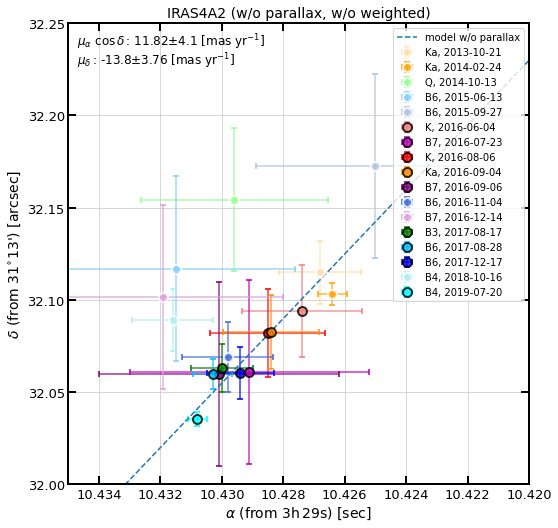

In [15]:
pm_ra  = pm_ra_fit_secyr
ra_0   = ra_0_fit_sec
pm_dec = pm_dec_fit_arcsyr
dec_0  = dec_0_fit_arcs

pm_ra_fmt      = pm_ra_fit_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_masyr_fmt
pm_dec_fmt     = pm_dec_fit_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_masyr_fmt

plot_title_name   = 'IRAS4A2 (w/o parallax, w/o weighted)'
plot_savefig_name = '%s4A2_radec_wo_prllx.pdf'%(path_figure)


plot_ra_dec(pm_ra, ra_0, pm_dec, dec_0, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, \
            plot_title_name, plot_savefig_name)

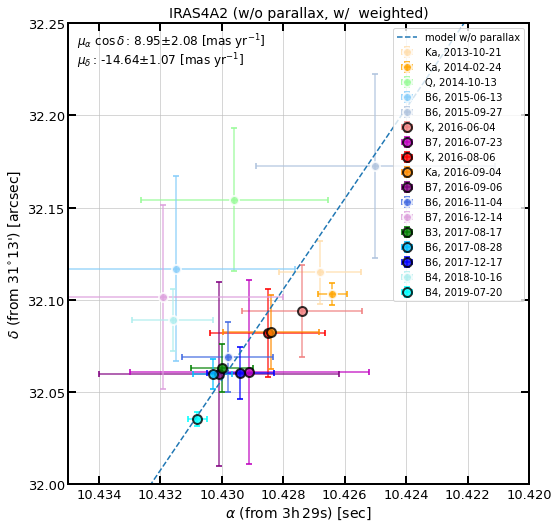

In [16]:
pm_ra  = pm_ra_fit_wt_secyr
ra_0   = ra_0_fit_wt_sec
pm_dec = pm_dec_fit_wt_arcsyr
dec_0  = dec_0_fit_wt_arcs

pm_ra_fmt      = pm_ra_fit_wt_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_wt_masyr_fmt
pm_dec_fmt     = pm_dec_fit_wt_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_wt_masyr_fmt

plot_title_name   = 'IRAS4A2 (w/o parallax, w/  weighted)'
plot_savefig_name = '%s4A2_radec_wo_prllx_wt.pdf'%(path_figure)


plot_ra_dec(pm_ra, ra_0, pm_dec, dec_0, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, \
            plot_title_name, plot_savefig_name)

#### plot figure: unit [mas]

In [17]:
def plot_ra_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt):
    
    # Plot the fitting result (pm_RA*cos(dec) v.s. Time)
    # a = pm_ra * cos(dec)
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_ra_arr):

        # x: t - t0 [yr]
        time_diff_yr     = time_diff_yr_fit_arr[i]

        # y: RA(t) [mas]
        ra_diff_mass   = (ra_mas_fit_arr[i] - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))
        # uncertainty for ra [mas]
        radec_err_mas = radec_err_mas_fit_arr[i]

        ax.errorbar(x    = time_diff_yr, \
                    y    = ra_diff_mass, \
                    yerr = radec_err_mas, \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

    # y = a                  * x + b
    # y = pm_ra*cos(dec) * x + ra_0
    y_ra_fit_masyr    = fit_m*t + fit_c
    y_ra_fit_mas_diff = (y_ra_fit_masyr - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))


    # plot the fitting result
    ax.plot(t, y_ra_fit_mas_diff, '--', color='tab:blue', label='model w/o parallax')

    #----------------------------------------------------
    # Set the figure
    # ax.set_title('pm_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
    ax.set_ylabel(r'$\Delta\, \alpha$ [mas]', fontsize=12)
    #ax.set_xlim(40, -80)
    ax.set_ylim(-80, 40)
    ax.text(0.03, 0.93, r'$\mu_{\alpha}$ $\cos\,\delta\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)


    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='lower left')

    plt.savefig(plot_savefig_name)
    plt.show()

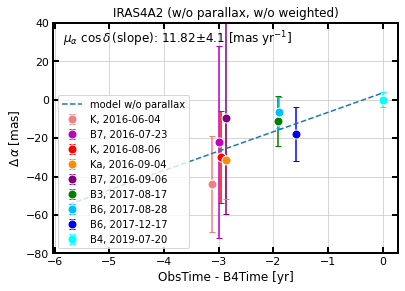

In [18]:
fit_m = pm_ra_fit_masyr
fit_c = ra_0_fit_mas
plot_title_name    = 'IRAS4A2 (w/o parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeRA_wo_prllx_mas.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_masyr_fmt

plot_ra_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

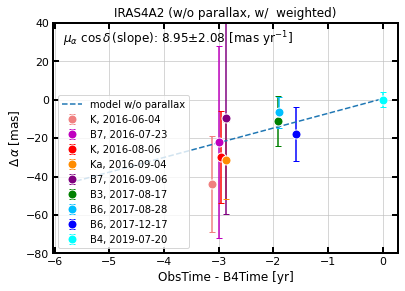

In [19]:
fit_m = pm_ra_fit_wt_masyr
fit_c = ra_0_fit_wt_mas
plot_title_name    = 'IRAS4A2 (w/o parallax, w/  weighted)'
plot_savefig_name  = '%s4A2_TimeRA_wo_prllx_mas_wt.pdf'%(path_figure)
plot_m_txt     = pm_ra_fit_wt_masyr_fmt
plot_m_err_txt = pm_ra_err_fit_wt_masyr_fmt

plot_ra_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [20]:
def plot_dec_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt):

    # Plot the fitting result (pm_Dec v.s. Time)
    # a = pm_dec
    fig = plt.figure()
    ax  = fig.add_axes([0.14,0.12,0.8,0.8]) # left, bottom, width, height (range 0 to 1)

    #----------------------------------------------------
    # Plot the observations
    for i, elm in enumerate(x_dec_arr):

        # x: t - t0 [yr]
        time_diff_yr     = time_diff_yr_fit_arr[i]

        # y: Dec(t) [mas]
        dec_diff_mas     = dec_mas_fit_arr[i] - dec_mas_std
        # uncertainty of ra [mas]
        radec_err_mas = radec_err_mas_fit_arr[i]

        ax.errorbar(x    = time_diff_yr, \
                    y    = dec_diff_mas, \
                    yerr = radec_err_mas, \
                    fmt='o', color = color_fit_list[i], \
                    alpha=1, markersize=9, markeredgecolor='w', markeredgewidth=1, capsize=3,\
                    label=Band_fit_arr[i]+', '+time_ymd_fit_arr[i])

    #----------------------------------------------------
    # plot the fitting result

    # Time
    t = np.linspace(t0_diff_yr, tf_diff_yr, 20)

    # y = a          * x + b
    # y = pm_dec * x + dec_0
    y_dec_fit_masyr = fit_m*t + fit_c
    y_dec_fit_diff_masyr   = y_dec_fit_masyr - dec_mas_std

    # plot the fitting result
    ax.plot(t, y_dec_fit_diff_masyr , '--', color='tab:blue', label='model w/o parallax')

    #----------------------------------------------------
    # Set the figure
    # ax.set_title('pm_ra*cos(dec) v.s. Time', fontsize=12)
    ax.set_title(plot_title_name, fontsize=12)
    ax.set_xlabel('ObsTime - B4Time [yr]', fontsize=12)
    ax.set_ylabel(r'$\Delta\, \delta$ [mas]', fontsize=12)
    #ax.set_xlim(40, -80)
    ax.set_ylim(-40, 80)
    ax.text(0.03, 0.93, r'$\mu_{\delta}\,$(slope): %s$\pm$%s [mas yr$^{-1}$]'\
            %(plot_m_txt, plot_m_err_txt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)


    # set the major and minor tickers
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_major_locator(MultipleLocator(30))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    # ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(which='major', direction='in', length=6, width=2, labelsize=11, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=11, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.grid(color='silver', alpha=0.8)
    ax.legend()

    plt.savefig(plot_savefig_name)
    plt.show()

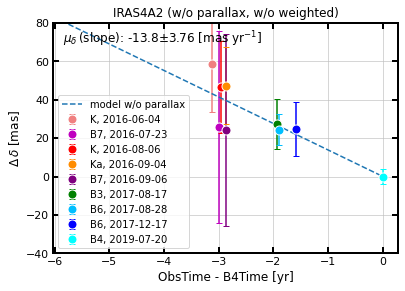

In [21]:
fit_m = pm_dec_fit_masyr
fit_c = dec_0_fit_mas
plot_title_name    = 'IRAS4A2 (w/o parallax, w/o weighted)'
plot_savefig_name  = '%s4A2_TimeDec_wo_prllx_mas.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_masyr_fmt

plot_dec_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

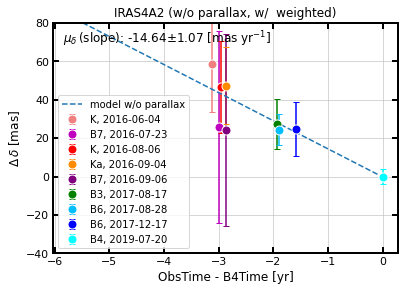

In [22]:
fit_m = pm_dec_fit_wt_masyr
fit_c = dec_0_fit_wt_mas
plot_title_name    = 'IRAS4A2 (w/o parallax, w/  weighted)'
plot_savefig_name  = '%s4A2_TimeDec_wo_prllx_mas_wt.pdf'%(path_figure)
plot_m_txt         = pm_dec_fit_wt_masyr_fmt
plot_m_err_txt     = pm_dec_err_fit_wt_masyr_fmt

plot_dec_time_mas(fit_m, fit_c, plot_title_name, plot_savefig_name, plot_m_txt, plot_m_err_txt)

In [23]:
def plot_ra_dec(pm_ra, ra_0, pm_dec, dec_0, pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, \
                plot_title_name, plot_savefig_name):
    
    # Plot the fitting result (RA v.s. Dec)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes([0.14,0.12,0.8,0.8]) 

    #---------------------------------------
    # Plot the observations
    for i, band in enumerate(Band_arr):

        # ra & dec difference [mas] between each and the standard (B4) obs.
        ra_diff_mas  = (ra_mas_arr[i] - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))
        dec_diff_mas = dec_mas_arr[i] - dec_mas_std

        # uncertainty of the coordinate
        radec_err_mas = radec_err_mas_arr[i]   
        
        markeredgecolor = 'w' if i in drop_list else 'k'

        ax.errorbar(x    = ra_diff_mas,\
                    y    = dec_diff_mas,\
                    xerr = radec_err_mas,\
                    yerr = radec_err_mas,\
                    fmt='o', color = color_list[i],\
                    alpha=0.8, markersize=9, markeredgecolor=markeredgecolor, markeredgewidth=1, capsize=3,\
                    label=band+', '+time_ymd_arr[i])

        #---------------------------------------
        # Plot the fitting result with corresponding observational time 

        # Time [yr]
        t_diff_yr       = time_diff_yr_arr[i]

        # x: ra(t)  - ra_std [mas]
        ra_fit_mas       = pm_ra  *t_diff_yr + ra_0
        ra_diff_fit_mas  = (ra_fit_mas  - ra_mas_std) * np.cos(np.deg2rad(dec_deg_std))

        # y: dec(t) - dec_std [mas]
        dec_fit_mas      = pm_dec *t_diff_yr + dec_0  
        dec_diff_fit_mas = dec_fit_mas - dec_mas_std

        ax.plot(ra_diff_fit_mas, dec_diff_fit_mas, color = color_list[i], alpha= 0.8,\
                marker='o', fillstyle = 'none', markeredgewidth=2, markersize=10, zorder=10)

    #---------------------------------------
    # plot the fitting result

    # Time
    t_diff_yr_arr = np.linspace(-15, 5, 20)

    # x: ra(t)  - ra_std  [mas]
    ra_fit_mas_arr       = pm_ra  *t_diff_yr_arr + ra_0
    ra_diff_fit_mas_arr  = (ra_fit_mas_arr  - ra_mas_std)* np.cos(np.deg2rad(dec_deg_std))
    
    # y: dec(t) - dec_std [mas]
    dec_fit_mas_arr      = pm_dec *t_diff_yr_arr + dec_0   
    dec_diff_fit_mas_arr = dec_fit_mas_arr - dec_mas_std

    # plot the fitting result
    ax.plot(ra_diff_fit_mas_arr, dec_diff_fit_mas_arr, '--', color='tab:blue', label='model w/o parallax')

    #---------------------------------------
    # Set the figure
    ax.set_title(plot_title_name, fontsize=14)
    ax.set_xlabel(r'$\Delta\,\alpha$ [mas]', fontsize=14)
    ax.set_ylabel(r'$\Delta\,\delta$ [mas]', fontsize=14)
    ax.set_xlim(25, -125)
    ax.set_ylim(-25, 200)

    ax.text(0.02, 0.96, r'$\mu_{\alpha}$ $\cos\,\delta\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_ra_fmt, pm_ra_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.02, 0.92, r'$\mu_{\delta}\,$: %s$\pm$%s [mas yr$^{-1}$]'\
            %(pm_dec_fmt, pm_dec_err_fmt), color='black', size=12, \
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.tick_params(which='major', direction='in', length=8, width=2, labelsize=13, top=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=2, labelsize=13, top=True, right=True)

    # set the width of the axes
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.grid(color='silver', alpha=0.8)
    ax.legend(loc='upper right')


    plt.savefig(plot_savefig_name)
    plt.show()

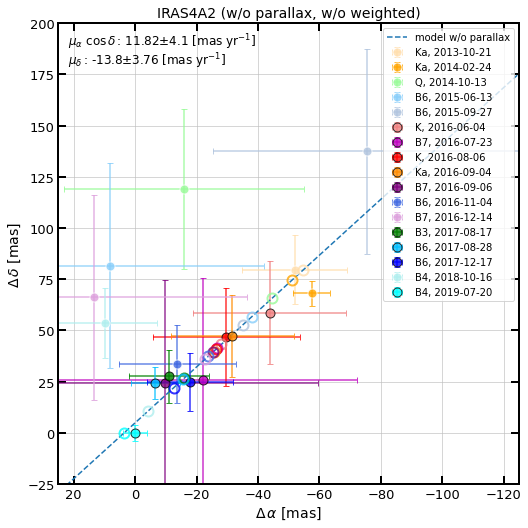

In [24]:
pm_ra  = pm_ra_fit_masyr
ra_0   = ra_0_fit_mas
pm_dec = pm_dec_fit_masyr
dec_0  = dec_0_fit_mas

pm_ra_fmt      = pm_ra_fit_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_masyr_fmt
pm_dec_fmt     = pm_dec_fit_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_masyr_fmt

plot_title_name   = 'IRAS4A2 (w/o parallax, w/o weighted)'
plot_savefig_name = '%s4A2_radec_wo_prllx_mas.pdf'%(path_figure)


plot_ra_dec(pm_ra, ra_0, pm_dec, dec_0, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, \
            plot_title_name, plot_savefig_name)

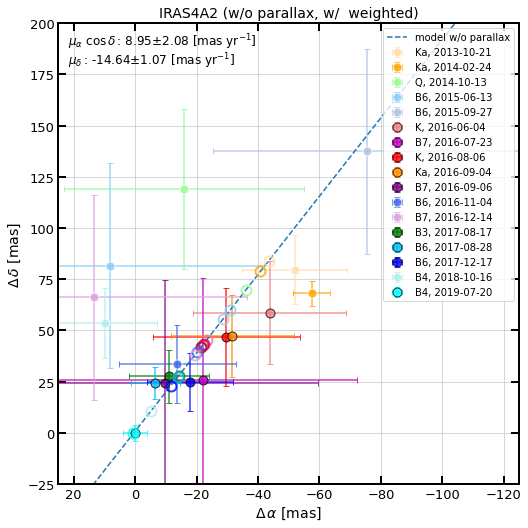

In [25]:
pm_ra  = pm_ra_fit_wt_masyr
ra_0   = ra_0_fit_wt_mas
pm_dec = pm_dec_fit_wt_masyr
dec_0  = dec_0_fit_wt_mas

pm_ra_fmt      = pm_ra_fit_wt_masyr_fmt
pm_ra_err_fmt  = pm_ra_err_fit_wt_masyr_fmt
pm_dec_fmt     = pm_dec_fit_wt_masyr_fmt
pm_dec_err_fmt = pm_dec_err_fit_wt_masyr_fmt

plot_title_name   = 'IRAS4A2 (w/o parallax, w/  weighted)'
plot_savefig_name = '%s4A2_radec_wo_prllx_mas_wt.pdf'%(path_figure)


plot_ra_dec(pm_ra, ra_0, pm_dec, dec_0, \
            pm_ra_fmt, pm_ra_err_fmt, pm_dec_fmt, pm_dec_err_fmt, \
            plot_title_name, plot_savefig_name)